In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk import word_tokenize
import boto3
from s3 import get_file
import re
import mglearn
import sklearn
import yellowbrick
from nltk.corpus import stopwords

In [2]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [3]:
s3 = boto3.resource('s3')
lyrics = get_file(s3,'s3ssp',download_file='NLP_Data/master_lyrics_audio_features.csv',rename_file='0320_2020_nlp.csv')

In [4]:
df = pd.read_csv(lyrics,sep='|',encoding='utf-8')

In [5]:
df = df.drop(columns=['instrumentalness','key','mode','liveness','speechiness','time_signature'])

In [6]:
df.head()

,artist_uri_x,artist_name,track_uri,track_name,lyrics,acousticness,danceability,energy,loudness,tempo,valence
0,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5Ui8M6tfknhXo4MuGHt3Dy,why don't you love me,"N-n-now, honey\nYou better sit down and look a...",0.0463,0.693,0.730,-4.571,136.882,0.7410
1,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5dhPqcLr5EcSd7Fe4fslCq,save the hero,I lay alone awake at night\nSorrow fills my ey...,0.6730,0.551,0.467,-10.364,116.966,0.1480
2,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5dWTQXVHdoIsSLpEyS3woy,broken-hearted girl,Youre everything I thought you never were\nAnd...,0.5030,0.336,0.424,-7.203,82.149,0.1590
3,6vWDO969PvNqNYHIOW5v0m,Beyoncé,0QRxJvOohS8yiGC1n98uFM,lift ev'ry voice and sing - homecoming live,He is always laughin' and flirting with me\nAn...,0.1240,0.127,0.409,-13.089,79.904,0.0782
4,6vWDO969PvNqNYHIOW5v0m,Beyoncé,4DActPOAtak2m8meZeMt3B,no angel,"This is for my fans\n(Uhu, uhu)\nThis is for m...",0.0424,0.571,0.466,-9.153,111.580,0.5120


In [7]:
df_lastfm_stopwords = pd.read_csv('lastfm-lyrics-analysis/stopwords.txt')

In [8]:
lyrics = df['lyrics'].str.replace('\n',' ')
df['lyrics'] = lyrics.to_frame()
lastfm_stopwords = df_lastfm_stopwords['a'].str.replace('\n',' ')
df_lastfm_stopwords['last_fm_stopwords'] = lastfm_stopwords.to_frame()
#df_clean = .str.replace('(\[.*\])*','')

In [9]:
df_lastfm_stopwords.head()

,a,last_fm_stopwords
0,able,able
1,about,about
2,above,above
3,abst,abst
4,accordance,accordance


In [10]:
df_lastfm_stopwords_list = df_lastfm_stopwords['last_fm_stopwords'].tolist()

In [11]:
#In development delete rows with instumental as its column

df = df.dropna()
df_lyrics = df['lyrics']
df_playlist = df
df_playlist['instrumental'] = df_lyrics.apply(lambda x: x.find('instrumental'))
df_playlist = df.drop(df[df['instrumental'] != -1].index)
#df = df.drop(df[df['lyrics']=='This is an instrumental'].index)

In [12]:
def lastfm_preprocessor(text):
    tokens = word_tokenize(text)
    return (" ").join([word for word in tokens if word not in df_lastfm_stopwords_list])

def nltk_preprocessor(text):
    stop_words = stopwords.words('english')
    tokens = word_tokenize(text)
    return (" ").join([word for word in tokens if word not in stop_words])

In [13]:
df_demo = df_playlist.sample(50)

df_demo['last_fm_lyrics'] = df_demo['lyrics'].apply(lambda x: lastfm_preprocessor(x))
df_demo['nltk_lyrics'] = df_demo['last_fm_lyrics'].apply(lambda x: nltk_preprocessor(x))

In [14]:
df_demo.head()

,artist_uri_x,artist_name,track_uri,track_name,lyrics,acousticness,danceability,energy,loudness,tempo,valence,instrumental,last_fm_lyrics,nltk_lyrics
63825,3pTE9iaJTkWns3mxpNQlJV,Bombay Bicycle Club,6ALADzSL0wmrNyZGlflqK1,many ways,"One spur in the fire, burning Now we're cleari...",0.841000,0.528,0.709,-9.914,77.492,0.784,-1,"One spur fire , burning Now 're clearing ember...","One spur fire , burning Now 're clearing ember..."
108884,5KEG7G8LDYlHgFDqZyEEs2,Chris Rea,2rNawLFXIfZ7A63OUE8hYO,e,Now there's no storyline Just a real good time...,0.286000,0.680,0.510,-13.389,131.983,0.227,-1,Now 's storyline Just a real good time And I n...,Now 's storyline Just real good time And I n't...
176681,3JDIAtVrJdQ7GFOX26LYpv,Accept,2JDpNgkNNeYjmhRjTQajF1,the beast inside,My mind is razor sharp And I'm wild-cat-mean I...,0.000135,0.486,0.611,-12.482,114.619,0.485,-1,My mind razor sharp And I 'm wild-cat-mean I '...,My mind razor sharp And I 'm wild-cat-mean I '...
111001,60GtR6PIcDY1pikPgKHNk9,Circle of Dust,2n6Q6yi1nUrcwUiClWJPZd,you are fragile,...you are fragile...,0.000101,0.503,0.881,-4.633,111.969,0.497,-1,... fragile ...,... fragile ...
18329,19I4tYiChJoxEO5EuviXpz,AFI,6Advyc7skv7R8VBPG9zKBO,perfect fit,"What was it I was thinking, or was I even thin...",0.000788,0.374,0.972,-4.155,160.907,0.706,-1,"What I thinking , I thinking ? When I I though...","What I thinking , I thinking ? When I I though..."


In [15]:
df_demo[['artist_name','track_name','lyrics','last_fm_lyrics','nltk_lyrics']].head(10)

,artist_name,track_name,lyrics,last_fm_lyrics,nltk_lyrics
63825,Bombay Bicycle Club,many ways,"One spur in the fire, burning Now we're cleari...","One spur fire , burning Now 're clearing ember...","One spur fire , burning Now 're clearing ember..."
108884,Chris Rea,e,Now there's no storyline Just a real good time...,Now 's storyline Just a real good time And I n...,Now 's storyline Just real good time And I n't...
176681,Accept,the beast inside,My mind is razor sharp And I'm wild-cat-mean I...,My mind razor sharp And I 'm wild-cat-mean I '...,My mind razor sharp And I 'm wild-cat-mean I '...
111001,Circle of Dust,you are fragile,...you are fragile...,... fragile ...,... fragile ...
18329,AFI,perfect fit,"What was it I was thinking, or was I even thin...","What I thinking , I thinking ? When I I though...","What I thinking , I thinking ? When I I though..."
85784,Angry Salad,red cloud,Climbing up on a hill that they knew well And ...,"Climbing a hill knew well And hillside , shado...","Climbing hill knew well And hillside , shadows..."
126036,Funkmaster Flex,r,"(Lauryn Hill) Yeah, we got Fugees up in here, ...","( Lauryn Hill ) Yeah , Fugees , haha ! ( Wycle...","( Lauryn Hill ) Yeah , Fugees , haha ! ( Wycle..."
224649,Armin van Buuren,drowning (feat. laura v) - avicii remix,"Rush, pull me under The world is at my feet an...","Rush , pull The feet 's wonder Your eyes speak...","Rush , pull The feet 's wonder Your eyes speak..."
164877,Buck-O-Nine,dear anna,I'm on the couch and I'm watching TV now I kno...,I 'm couch I 'm watching TV I leave I 'm a bor...,I 'm couch I 'm watching TV I leave I 'm bored...
122514,Funkmaster Flex,r,It's another one of them old phunky Cypress Hi...,"It 's phunky Cypress Hill things , I 'm sayin ...","It 's phunky Cypress Hill things , I 'm sayin ..."


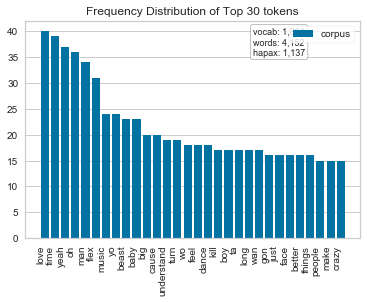

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer

# Load the text data


vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(df_demo['nltk_lyrics'])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',n=30)
visualizer.fit(docs)
visualizer.show()

In [17]:
#Control Panel - Hyper Parameters

#Count Vectorizer
max_features = 500 #500
max_df = .08



#LDA
n_topics = 3  #10


#LDA Display
display_n_chunks = 2 #5
n_topics = 10        #20
n_words = 5        #5



In [18]:
#Count Vectorizer
vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
X = vect.fit_transform(df_demo['nltk_lyrics'])

## Topic Analysis

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=n_topics, learning_method="batch",
                                max_iter=15, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_topics), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)





lda.components_.shape: (10, 500)
topic 0       topic 1       
--------      --------      
dance         kill          
mind          dog           
brain         raw           
days          goodbye       
mother        minutes       


topic 2       topic 3       
--------      --------      
turn          angel         
cherry        fallen        
look          highest       
shine         curse         
yellow        darkest       


topic 4       topic 5       
--------      --------      
doin          yo            
stop          vocãª         
lah           nã            
shoot         ela           
cloud         apart         


topic 6       topic 7       
--------      --------      
beast         scared        
inside        weekend       
running       knew          
living        kashchei      
infected      doctor        


topic 8       topic 9       
--------      --------      
music         woods         
boy           walker        
make          sun           
co

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [22]:
def playlist_element(topics=range(n_topics), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words):
    playlists = []
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        #print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        #print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                #print(("{:<14}" * len_this_chunk).format(
                #    *feature_names[sorting[these_topics, i]]))
                playlists.append(feature_names[sorting[these_topics, i]][0])
            except:
                pass
        print("\n")
    return playlists

In [23]:
playlists = playlist_element()

In [24]:
playlists[0]

'dance'

In [29]:
def create_ssp(n_words,playlists):
    playlist = []
    for x in range(n_words):
        playlist.append(playlists[x])
    return playlist
        
        
    

In [30]:
playlist = create_ssp(n_words,playlists)

In [31]:
playlist

['dance', 'mind', 'brain', 'days', 'mother']

## Rough

In [64]:
def find_lyrics(lyrics,element,playlist_position):
    if(lyrics.find(element)!= -1):
        return playlist_position
    else:
        return None


In [65]:
def make_ssp(playlist):
    df_demo_ssp = df_demo
    ssp = []
    for slot in range(len(playlist)):
#reset to org state
        df_demo_ssp['playlist_index_{s}'.format(s=slot)] = df_demo_ssp.apply(lambda x: find_lyrics(x['lyrics']
                                                                            ,playlist[slot],slot),axis=1)
        x = df_demo_ssp.dropna()
        y = x[(x['valence'] == x['valence'].max())]
        z = y[(y['energy'] == y['energy'].max())]

        print(z.track_uri.values[0])
        ssp.append({'artist_name':z.artist_name.values[0],'track_name':z.track_name.values[0],'track_uri':z.track_uri.values[0],
                   'valence':y.valence.values[0],'energy':z.energy.values[0],'lyrics':z.lyrics.values[0]})

        df_demo_ssp = df_playlist.drop(index=z.index)
    return ssp

In [66]:
ssp = make_ssp(playlist)
#playlist[0]

3V368AqKw3yoyEBwXWXW8s
5jjt6Qa4PbsgpEMgz5WzL1
2n3CaPGPLYnYAvTEwKCX8t
1COL3FWo7ChOKTpdKURf3r
2ymOkI2ARTirkd7l5Nk2cw


In [68]:
df_ssp = pd.DataFrame(ssp)
df_ssp

,artist_name,energy,lyrics,track_name,track_uri,valence
0,Avicii,0.699,"So bold and fine, I've known you for some time...",dear boy - avicii by avicii,3V368AqKw3yoyEBwXWXW8s,0.575
1,A*Teens,0.976,"Floorfiller, floorfiller, floorfiller Hey Mr. ...",floorfiller - radio edit,5jjt6Qa4PbsgpEMgz5WzL1,0.990
2,Austin Mahone,0.922,Austin man keep doin yo thing Let these boys k...,mmm yeah (feat. pitbull),2n3CaPGPLYnYAvTEwKCX8t,0.976
3,Freddie Hart,0.575,(For two days) she is an angel (the next day) ...,heaven only knows,1COL3FWo7ChOKTpdKURf3r,0.976
4,The Boomtown Rats,0.912,Tell me what you're doing coming in so late at...,never bite the hand that feeds,2ymOkI2ARTirkd7l5Nk2cw,0.981


## Visualization (Valence Curve, Energy Curve)

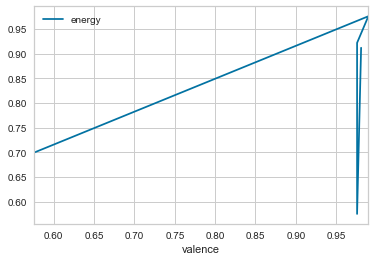

In [69]:
df_ssp.plot.line(x='valence',y='energy')

## Create Spotify Playlist

In [70]:
import requests
import json
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

In [71]:
cid = '049ade7215e54c63a2b628f3784dc407'
secret = '5d30770120ad4dbbabbb5ce538110e05'
redirect_uri = 'http://google.com/'
username = 'name'

In [75]:
#Authentication

scope = 'playlist-modify-private'
token_playlist = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_playlist:
    sp_playlist = spotipy.Spotify(auth=token_playlist)
else:
    print("Can't get token for", username)
    
#Authentication

scope = 'user-read-private'
token_user = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_user:
    sp_user = spotipy.Spotify(auth=token_user)
else:
    print("Can't get token for", username)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=049ade7215e54c63a2b628f3784dc407&response_type=code&redirect_uri=http%3A%2F%2Fgoogle.com%2F&scope=playlist-modify-private in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQBEkOsV9DdQCmklfBdDzO444VtzrnRDLLrJHuQM47HhV8RzlbMH4VlUJ-1Z_sBOtyzOQBKMzUDB1MhFCugc2QOpkA2XQaOIve0NLFo5S4q6IGaVtll-d185uQoUkNYRs0lLgo85GPJ5l3kBe8Mrc1sbBMjM_E9ZjgXAF3SMeabS-WYaomI74RbQXbXLN140wJ3W2z7RnDMPryiOT9LGAuc




            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you wer

In [76]:
def get_user_id(url):
    try:
        resp = requests.get(url,headers={'Authorization': 'Bearer ' + token_user},
                             #data={"name": "SSP"}
                           )
        
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
    
    response = resp.json()
    userid = response['id']
    
    return userid


In [77]:
user_id = get_user_id('https://api.spotify.com/v1/me')

In [78]:
identification = user_id
identification

'124399179'

In [79]:
playlist = sp_playlist.user_playlist_create(identification,'SSP', public=False, description="First SSP")

In [80]:
playlist

{'collaborative': False,
 'description': 'First SSP',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/2IqRNLDLAvUxRpWaDta7dH'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/2IqRNLDLAvUxRpWaDta7dH',
 'id': '2IqRNLDLAvUxRpWaDta7dH',
 'images': [],
 'name': 'SSP',
 'owner': {'display_name': 'Adam Goldstein',
  'external_urls': {'spotify': 'https://open.spotify.com/user/124399179'},
  'href': 'https://api.spotify.com/v1/users/124399179',
  'id': '124399179',
  'type': 'user',
  'uri': 'spotify:user:124399179'},
 'primary_color': None,
 'public': False,
 'snapshot_id': 'MSxjMmE2ZDg5NmM0NzIzNGFiODY3OGI0MWEzMDk1NzViMTQ0MDU5MTYw',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/2IqRNLDLAvUxRpWaDta7dH/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:playlist:2IqRNLDLAvUxRpWaDta7dH'}

In [81]:
playlist_tracks = sp_playlist.user_playlist_add_tracks(identification,playlist['id'],df_ssp['track_uri'], position=None)

## unigrams

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#How many words per topic
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)